In [1]:

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

from keras.layers import RepeatVector, Reshape, Concatenate, multiply

batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 120
data_augmentation = True
num_classes = 10

subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3
version = 2
depth = n * 9 + 2

model_type = 'ResNet%dv%d' % (depth, version)


# import matplotlib.pyplot as plt
# %matplotlib inline
# import numpy as np

# x_train = np.load('data/x_train.npy')
# y_train = np.load('data/y_train.npy')
# x_test = np.load('data/x_test.npy')
# y_test = np.load('data/y_test.npy')

# # print('x_train shape:', x_train.shape)
# # print(x_train.shape[0], 'train samples')
# # print(x_test.shape[0], 'test samples')

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')

# input_shape = x_train.shape[1:]

# # if subtract_pixel_mean:
# #     x_train_mean = np.mean(x_train, axis=0)
# #     x_train -= x_train_mean
# #     x_test -= x_train_mean

# # print('x_train shape:', x_train.shape)
# # print(x_train.shape[0], 'train samples')
# # print(x_test.shape[0], 'test samples')
# # print('y_train shape:', y_train.shape)

# x_train.shape, y_train.shape, x_test.shape, y_test.shape


Using TensorFlow backend.


In [2]:
model_type

'ResNet29v2'

In [3]:
# epochs = 120


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x





def resnet_v2(input_shape, depth, num_classes=10):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    enc_feat = Input(shape=(256,))
    
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out-size = (None, 8, 8, 256)
    
    
    # start attention block
#     res_feat = Input(shape=(hh,hh,cc))
#     enc_feat = Input(shape=(cc,))
    res_feat = x
    enc_feat_c = RepeatVector(64)(enc_feat)
#     enc_feat_c = K.repeat_elements(enc_feat, 64, axis=1)
    enc_feat_c = Reshape(target_shape=(8,8,256))(enc_feat_c)
    
    x = keras.layers.concatenate([res_feat, enc_feat_c], axis=-1) #(8,8,512)
#     print(x)
#     print(Conv2D(256,(1, 1), padding='same')(x))
    x = Conv2D(256,(1, 1), #gfhfghfg
               padding='same',
               kernel_initializer='he_normal')(x) #(8,8,256)
    x = Activation('relu')(x)
#     print(x)
    # softmax to calculate weights
    x = Reshape(target_shape=(64,256))(x)
#     print(x)
    x = Dense(1, activation='softmax')(x) #(8,8,1)
#     print(x)
    x = Reshape(target_shape=(8,8,1))(x)
#     print(x)
#     x = Dense(1)(x) #(8,8,1)
#     print(x)
    # weighted multiply
    x = multiply([x, res_feat]) # (8,8,256)
#     print(x)
    # skip connection
    x = keras.layers.concatenate([x, res_feat], axis=-1)
#     print(x)
#     print(x)
    x = Conv2D(256,(1, 1), 
               padding='same',
               kernel_initializer='he_normal')(x) #(8,8,256)
#     print(x)
#     print(x)
#     att_feat = Model(inputs=[res_feat, enc_feat], outputs=x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256,(3, 3), 
               padding='same',
               kernel_initializer='he_normal')(x) #(8,8,256)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    
    final_out = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)


    model = Model(inputs=[inputs, enc_feat], outputs=final_out)
    
    
#     x = AveragePooling2D(pool_size=8)(x)
#     y = Flatten()(x)
#     outputs = Dense(num_classes,
#                     activation='softmax',
#                     kernel_initializer='he_normal')(y)

    # Instantiate model.
#     model = Model(inputs=inputs, outputs=x)
    return model

input_shape = (32,32,3)
resnet = resnet_v2(input_shape=input_shape, depth=depth)
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

def _encoder():
    input_img = Input(shape=(32, 32, 3), name='encoded_feature')

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    model1 = Model(input_img, encoded)
    
    return model1



enc         = _encoder()
enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_feature (InputLayer) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
__________

In [3]:
def _decoder():
    input_img = Input(shape=(2, 2, 64), name='decoded_feature')
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    model2 = Model(input_img, decoded)
    return model2

dec = _decoder()
dec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoded_feature (InputLayer) (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          18464     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 16)        0         
__________

In [4]:
input_img   = Input(shape=(32,32,3), name='autoencoder')
enc         = enc(input_img)
decoded     = dec(enc)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 2, 2, 64)          24528     
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 3)         61395     
Total params: 85,923
Trainable params: 85,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
# earlystopper = EarlyStopping(patience=3, verbose=1)
# checkpointer = ModelCheckpoint('autoencoder.h5', verbose=1, 
#                                save_best_only=True, 
#                                mode='auto', period=1)


In [5]:
def lr_schedule_auto(epoch):
    lr = 1e-3
    if epoch > 30:
        lr *= 0.5e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [6]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_autoencoder.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint_auto = ModelCheckpoint(filepath=filepath,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True)

lr_scheduler_auto = LearningRateScheduler(lr_schedule_auto)

lr_reducer_auto = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                    cooldown=0,
                                    patience=5,
                                    min_lr=0.5e-6)

callbacks = [checkpoint_auto, lr_reducer_auto, lr_scheduler_auto]


In [7]:
autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)#,
#                 callbacks=[TensorBoard(log_dir='autoencoder/')])


Train on 50000 samples, validate on 10000 samples
Epoch 1/2
Learning rate:  0.001
50000/50000 [==============================] - 7s 135us/step - loss: 0.6861 - val_loss: 0.6849

Epoch 00001: val_loss improved from inf to 0.68492, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_autoencoder.001.h5
Epoch 2/2
Learning rate:  0.001
50000/50000 [==============================] - 3s 53us/step - loss: 0.6832 - val_loss: 0.6813

Epoch 00002: val_loss improved from 0.68492 to 0.68131, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_autoencoder.002.h5


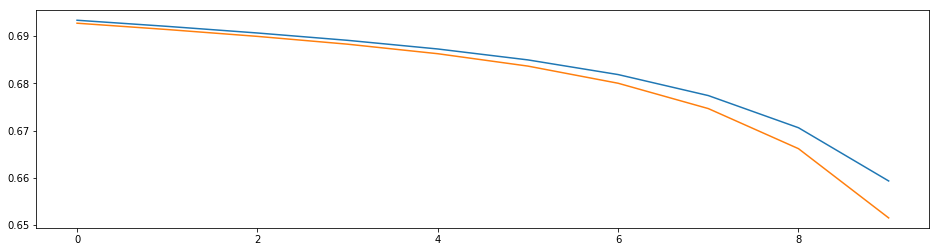

In [10]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
ax.plot(range(10),autoencoder.history.history['loss'], range(10),autoencoder.history.history['val_loss'])

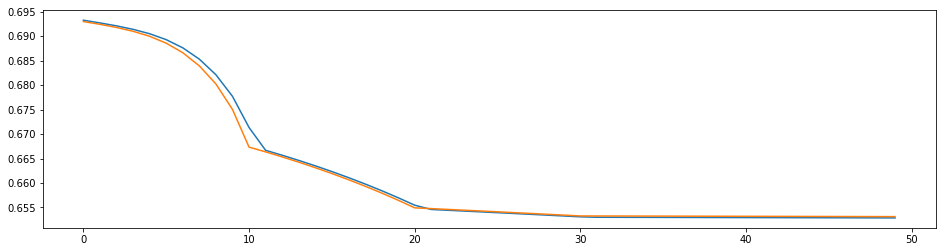

In [10]:
fig, ax = plt.subplots(1,1, figsize=(16,4))

ax.plot(range(50),autoencoder.history.history['loss'], range(50),autoencoder.history.history['val_loss'])

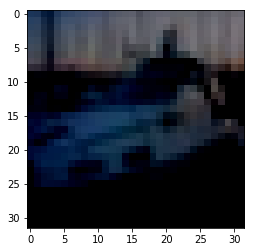

In [8]:
plt.imshow(x_test[2])

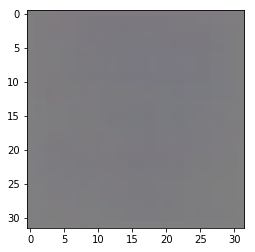

In [11]:
temp = x_test[6]#+0.5
pred = autoencoder.predict(temp.reshape(-1,32,32,3))
plt.imshow(pred[0])

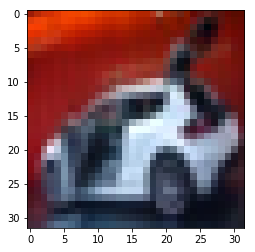

In [10]:
# temp = np.where(temp>0.5,1,0)
plt.imshow(temp)

In [25]:
temp = x_test[6]+0.5
pred = enc(temp.reshape(-1,32,32,3))
print(pred.shape)
plt.imshow(pred)

TypeError: 'Tensor' object is not callable

In [2]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np



In [3]:
def autoencoder():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(16, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)


    model = Model(input_img, decoded)
    return model

model = autoencoder()
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
__________

In [4]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_autoencoder.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


In [5]:
# model.load_weights(saveDir + "AutoEncoder_Cifar10_Deep_weights.05-0.56-0.56.hdf5")

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
# chkpt = saveDir + 'AutoEncoder_Cifar10_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = filepath, 
                        monitor='val_loss', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='auto')


history = model.fit(x_train, x_train,
                    batch_size=64,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, x_test),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)



Train on 50000 samples, validate on 10000 samples
Epoch 1/20


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv2d_1/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv2d_1/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]
	 [[{{node loss/mul/_363}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2895_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

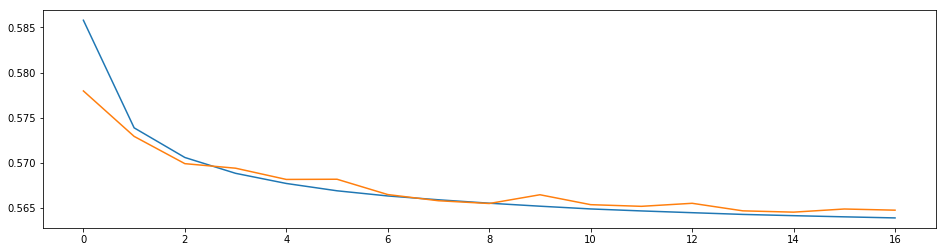

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,4))

ax.plot(range(17),model.history.history['loss'], range(17),model.history.history['val_loss'])


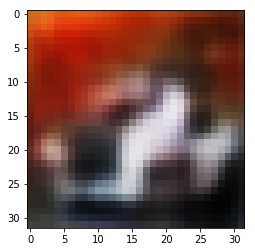

In [9]:
temp = x_test[6]#+0.5
pred = model.predict(temp.reshape(-1,32,32,3))
plt.imshow(pred[0])

In [4]:
model.load_weights('saved_models/cifar10_autoencoder.015.h5')
print("loaded successfully")

loaded successfully


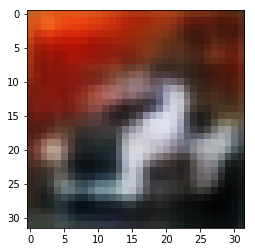

In [5]:
temp = x_test[6]#+0.5
pred = model.predict(temp.reshape(-1,32,32,3))
plt.imshow(pred[0])

In [ ]:
# from keras import backend as K

# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# # Testing
# test = np.random.random(input_shape)[np.newaxis,...]
# layer_outs = [func([test, 1.]) for func in functors]
# print layer_outs

In [6]:
encoded_output = K.function([model.input],
                            [model.layers[-16].output])
# layer_output = encoded_output([x])[0]

encoded_output

In [9]:
pred = encoded_output([x_test[6].reshape(-1,32,32,3)])
len(pred), pred[0].shape

(1, (1, 4, 4, 16))

In [24]:
pred = encoded_output([x_test[:5]])
len(pred), pred[0].shape

(1, (5, 4, 4, 16))

error: OpenCV(4.0.0) /io/opencv/modules/imgproc/src/histogram.cpp:152: error: (-215:Assertion failed) j < nimages in function 'histPrepareImages'


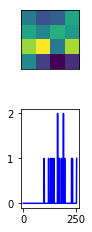

In [23]:
import cv2
# definition to show original image and reconstructed image
def showOrigDec(orig, num=16):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20,4))
    
    for i in range(16):
        
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(4,4))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
#         ax = plt.subplot(2, n, i +1 + n)
#         plt.imshow(orig[i+8].reshape(4,4))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
        
#         # display histogram
#         ax = plt.subplot(2, n, i +1 + n)
#         plt.hist((orig[i]*255).ravel(),256,[0,256])
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)        
        
        ax = plt.subplot(2, n, i +1 + n )
        color = ('b','g','r')
        for j,col in enumerate(color):
            histr = cv2.calcHist([((orig[i]/np.max(orig[i]))*255)],[j],None,[256],[0,256])
            plt.plot(histr,color = col)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
    plt.show()

showOrigDec(np.transpose(np.squeeze(pred[0]),(2,0,1)))

In [22]:
np.min(pred[0]), np.max(pred[0])

(0.0, 3.4354653)

In [ ]:
encoder_model = Model(model.inputs, model.layers[-16].output)
encoder_model.summary()

In [43]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x




def resnet_v2(encoder_model, input_shape, depth, num_classes=10):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
#     enc_feat = Input(shape=(256,))
    
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out-size = (None, 8, 8, 256)
    
    
    # start attention block
#     res_feat = Input(shape=(hh,hh,cc))
#     enc_feat = Input(shape=(cc,))
    res_feat = x
    print(inputs)
    print(encoder_model)
    
#     encoded_output = K.function([encoder_model.input], 
#                                 [encoder_model.layers[-16].output])

    enc_feat = encoder_model.predict(inputs)
    print(enc_feat)
#     enc_feat = enc_feat[0]
    enc_feat = Reshape(target_shape=(256))(enc_feat)
#     enc_feat = encoder_model.predict
    enc_feat_c = RepeatVector(64)(enc_feat)
#     enc_feat_c = K.repeat_elements(enc_feat, 64, axis=1)
    enc_feat_c = Reshape(target_shape=(8,8,256))(enc_feat_c)
    
    x = keras.layers.concatenate([res_feat, enc_feat_c], axis=-1) #(8,8,512)
#     print(x)
#     print(Conv2D(256,(1, 1), padding='same')(x))
    x = Conv2D(256,(1, 1), #gfhfghfg
               padding='same',
               kernel_initializer='he_normal')(x) #(8,8,256)
    x = Activation('relu')(x)
#     print(x)
    # softmax to calculate weights
    x = Reshape(target_shape=(64,256))(x)
#     print(x)
    x = Dense(1, activation='softmax')(x) #(8,8,1)
#     print(x)
    x = Reshape(target_shape=(8,8,1))(x)
#     print(x)
#     x = Dense(1)(x) #(8,8,1)
#     print(x)
    # weighted multiply
    x = multiply([x, res_feat]) # (8,8,256)
#     print(x)
    # skip connection
    x = keras.layers.concatenate([x, res_feat], axis=-1)
#     print(x)
#     print(x)
    x = Conv2D(256,(1, 1), 
               padding='same',
               kernel_initializer='he_normal')(x) #(8,8,256)
#     print(x)
#     print(x)
#     att_feat = Model(inputs=[res_feat, enc_feat], outputs=x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256,(3, 3), 
               padding='same',
               kernel_initializer='he_normal')(x) #(8,8,256)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    
    final_out = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)


    model = Model(inputs=[inputs, enc_feat], outputs=final_out)
    
    
#     x = AveragePooling2D(pool_size=8)(x)
#     y = Flatten()(x)
#     outputs = Dense(num_classes,
#                     activation='softmax',
#                     kernel_initializer='he_normal')(y)

    # Instantiate model.
#     model = Model(inputs=inputs, outputs=x)
    return model

# encoded_output = K.function([model.input], [model.layers[-16].output])

resnet = resnet_v2(encoder_model, input_shape=input_shape, depth=depth)
resnet.summary()

Tensor("input_10:0", shape=(?, 32, 32, 3), dtype=float32)


ValueError: When feeding symbolic tensors to a model, we expect thetensors to have a static batch size. Got tensor with shape: (None, 32, 32, 3)

In [36]:
encoder_model = Model(model.inputs, model.layers[-16].output)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
__________

In [35]:
model.layers[-16].output

<tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 4, 4, 16) dtype=float32>

In [40]:
encoder_model.predict(x_test[:2]).shape

(2, 4, 4, 16)

In [38]:
K.tensor_array_ops(x_test[:2])

TypeError: 'module' object is not callable

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
# print(model_type)


In [3]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True,
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    resnet_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,steps_per_epoch=int(1500/4),
                        callbacks=callbacks)



Using real-time data augmentation.
Epoch 1/120
Learning rate:  0.001
375/375 [==============================] - 34s 89ms/step - loss: 2.0231 - acc: 0.4488 - val_loss: 1.9742 - val_acc: 0.4512

Epoch 00001: val_acc improved from -inf to 0.45120, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_ResNet29v2_model.001.h5
Epoch 2/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 1.5501 - acc: 0.5942 - val_loss: 1.6276 - val_acc: 0.5580

Epoch 00002: val_acc improved from 0.45120 to 0.55800, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_ResNet29v2_model.002.h5
Epoch 3/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 1.3303 - acc: 0.6589 - val_loss: 1.9159 - val_acc: 0.5146

Epoch 00003: val_acc did not improve from 0.55800
Epoch 4/120
Learning rate:  0.001
375/375 [==============================] - 25s 65ms/step - loss: 1.1735 - acc: 0.7105 

375/375 [==============================] - 25s 66ms/step - loss: 0.5417 - acc: 0.8935 - val_loss: 0.8371 - val_acc: 0.8049

Epoch 00032: val_acc did not improve from 0.84760
Epoch 33/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 0.5276 - acc: 0.8969 - val_loss: 0.8034 - val_acc: 0.8144

Epoch 00033: val_acc did not improve from 0.84760
Epoch 34/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 0.5283 - acc: 0.8992 - val_loss: 0.7692 - val_acc: 0.8251

Epoch 00034: val_acc did not improve from 0.84760
Epoch 35/120
Learning rate:  0.001
375/375 [==============================] - 25s 65ms/step - loss: 0.5181 - acc: 0.9022 - val_loss: 0.7207 - val_acc: 0.8383

Epoch 00035: val_acc did not improve from 0.84760
Epoch 36/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 0.5216 - acc: 0.9002 - val_loss: 0.8878 - val_acc: 0.7994

Epoch 00036: val_acc did not improve fro

Epoch 104/120
Learning rate:  0.0001
375/375 [==============================] - 25s 66ms/step - loss: 0.2076 - acc: 0.9893 - val_loss: 0.5060 - val_acc: 0.9166

Epoch 00104: val_acc did not improve from 0.91980
Epoch 105/120
Learning rate:  0.0001
375/375 [==============================] - 24s 65ms/step - loss: 0.2068 - acc: 0.9885 - val_loss: 0.5086 - val_acc: 0.9162

Epoch 00105: val_acc did not improve from 0.91980
Epoch 106/120
Learning rate:  0.0001
375/375 [==============================] - 24s 65ms/step - loss: 0.2033 - acc: 0.9888 - val_loss: 0.5114 - val_acc: 0.9159

Epoch 00106: val_acc did not improve from 0.91980
Epoch 107/120
Learning rate:  0.0001
375/375 [==============================] - 25s 66ms/step - loss: 0.2020 - acc: 0.9891 - val_loss: 0.5222 - val_acc: 0.9141

Epoch 00107: val_acc did not improve from 0.91980
Epoch 108/120
Learning rate:  0.0001
375/375 [==============================] - 25s 66ms/step - loss: 0.2007 - acc: 0.9891 - val_loss: 0.5005 - val_acc: 0.9

In [4]:
model.history.history

{'acc': [0.4488333333333333,
  0.5942817817817818,
  0.6588463463264582,
  0.7104813146479814,
  0.7433683683484803,
  0.7656406406605287,
  0.7771312980044075,
  0.7963588588787469,
  0.8051801802000683,
  0.8135844177709726,
  0.8228436769705675,
  0.8301426426625308,
  0.8394853186122091,
  0.8415498831966618,
  0.8448031364896912,
  0.8500583917051703,
  0.8566691691890572,
  0.8581081081081081,
  0.8672213880746095,
  0.8644269269269269,
  0.869411077724523,
  0.8730814147083052,
  0.8739364364563246,
  0.8773982315648983,
  0.8806041666666666,
  0.8813813814211576,
  0.8868034701169154,
  0.8863238238238238,
  0.8898481815148482,
  0.8934976643707738,
  0.8940815815815816,
  0.8935602268935602,
  0.8969177511043058,
  0.8992534200668654,
  0.90219386056697,
  0.9001918585053038,
  0.8997122122321003,
  0.9054888221554889,
  0.9046129462398368,
  0.9053636970104756,
  0.9066983650118102,
  0.9085335335335335,
  0.9076159492428397,
  0.910472972972973,
  0.9129754754754755,
  0.909

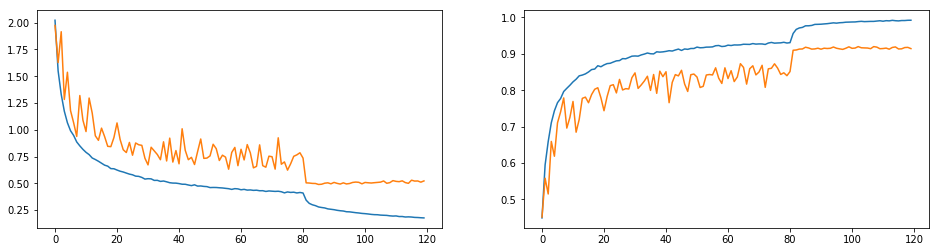

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

ax[0].plot(range(120),model.history.history['loss'], range(120),model.history.history['val_loss'])
ax[1].plot(range(120),model.history.history['acc'], range(120),model.history.history['val_acc'])

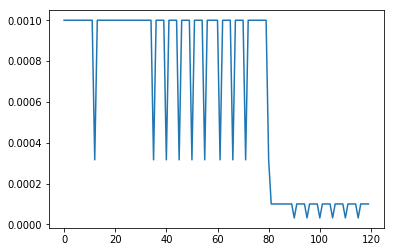

In [7]:
plt.plot(model.history.history['lr'])

In [8]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


10000/10000 [==============================] - 3s 267us/step
Test loss: 0.5226242788314819
Test accuracy: 0.9143
